In [4]:

import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import talib as ta
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'talib'

In [2]:
df = pd.read_csv("../DecisionTree_AMZN.csv", delimiter = ',', index_col = 'date', parse_dates = True)
df = df.loc[df['Name'] == 'AMZN']
df['volume'] = df['volume'] / df['volume'].rolling(20).mean()
df['range'] = (df['high'] - df['low']) / ta.ATR(df.high.values, df.low.values, df.close.values, 20)
df['return'] = df.open.shift(-2) - df.open.shift(-1)
df['EMA10'] = ta.EMA(df['close'].values, timeperiod = 10)
df['EMA30'] = ta.EMA(df['close'].values, timeperiod = 30)
df['ATR'] = ta.ATR(df['high'].values, df['low'].values, df['close'].values, timeperiod = 14)
df['ADX'] = ta.ADX(df['high'].values, df['low'].values, df['close'].values, timeperiod = 14)
df['RSI'] = ta.RSI(df['close'].values, timeperiod = 14)
macd, macdsignal, macdhist = ta.MACD(df['close'].values, fastperiod = 12, slowperiod = 26, signalperiod = 9)
df['MACD'] = macd
df['MACDsignal'] = macdsignal
df['ClgtEMA10'] = np.where(df['close'] > df['EMA10'], 1, -1)
df['EMA10gtEMA30'] = np.where(df['EMA10'] > df['EMA30'], 1, -1)
df['MACDSIGgtMACD'] = np.where(df['MACDsignal'] > df['MACD'], 1, -1)
df['target_cls'] = np.where(df['return'] > 0, 1, 0)
df['target_rgs'] = df['return']
df.dropna(inplace = True)
#df.drop(['Name'], axis = 1, inplace = True)
print(df.head())

FileNotFoundError: [Errno 2] File b'DecisionTree_AMZN.csv' does not exist: b'DecisionTree_AMZN.csv'

In [62]:
predictors = ['ATR', 'ADX','RSI', 'ClgtEMA10', 'EMA10gtEMA30', 'MACDSIGgtMACD']
X = df[predictors]
X.tail()

,ATR,ADX,RSI,ClgtEMA10,EMA10gtEMA30,MACDSIGgtMACD
date,,,,,,
2017-07-27,17.729313,24.748665,66.937125,1,1,-1
2017-07-28,19.677219,24.043752,54.053399,-1,1,-1
2017-07-31,20.630275,22.688939,42.981941,-1,1,1
2017-08-01,20.486684,21.430899,46.082418,-1,1,1
2017-08-02,20.557635,20.026780,45.986355,-1,1,1


In [63]:

y_cls = df.target_cls
y_rgs = df.target_rgs


In [64]:
from sklearn.model_selection import train_test_split
X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(X, y_cls, test_size = 0.25, random_state = 42, stratify = y_cls)
print (X_cls_train.shape, y_cls_train.shape)
print (X_cls_test.shape, y_cls_test.shape)

(652, 6) (652,)
(218, 6) (218,)


In [65]:
train_length = int(len(df)*0.75)
X_rgs_train = X[:train_length]
X_rgs_test = X[train_length:]
y_rgs_train = y_rgs[:train_length]
y_rgs_test = y_rgs[train_length:]

print (X_rgs_train.shape, y_rgs_train.shape)
print (X_rgs_test.shape, y_rgs_test.shape)


(652, 6) (652,)
(218, 6) (218,)


In [66]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3, min_samples_leaf = 6)
clf

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [67]:

clf = clf.fit(X_cls_train, y_cls_train)
clf


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

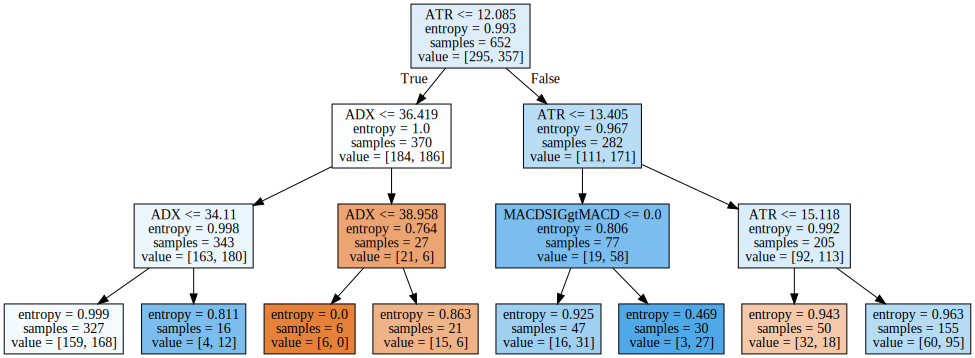

In [68]:
from sklearn import tree
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None,filled=True,feature_names=predictors)
#print(dot_data)
graphviz.Source(dot_data)

In [69]:

from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(min_samples_leaf = 200)

In [70]:
dtr.fit(X_rgs_train, y_rgs_train)


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=200,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

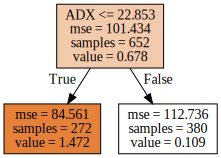

In [71]:
dot_data = tree.export_graphviz(dtr, out_file = None, filled = True, feature_names=predictors)
graphviz.Source(dot_data)